# Baseline Refresh Code Example

#### In this code we demonstrate the implementation of a **baseline refresh** for the different exposure methods

#### **Step 1:** Import modules

In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import tkinter

#### **Step 2:** Define the function for each strategy ( Brute Force, Linearisation, Conservative, Averages )

**NOTE:** For a detailed explanation of the NGR approach for calculating PSR, refer to original notebook

In [18]:
def PSR_NGR(positions, addonfactor, singleposition):

    GrossExposure = 0
    CurrentExposure = 0
    NetExposure = 0
    AddOn_Gross = 0

    if singleposition == True:
        GrossExposure += max(0, positions[0])
        CurrentExposure += positions[0]
        AddOn_Gross += addonfactor * positions[1]
    else:
        for i in range(len(positions)):
            GrossExposure += max(0, positions[i,0])
            CurrentExposure += positions[i,0]
            AddOn_Gross += addonfactor * positions[i,1]

    NetExposure = max(0, CurrentExposure)

    if GrossExposure == 0:
        NGR = 0
    else:
        NGR = NetExposure/GrossExposure
    
    PSR = max(0, CurrentExposure) + NGR * (0.6) * (AddOn_Gross) + (0.4) * (AddOn_Gross)

    return PSR



def PSR_Conservative(positions, addonfactor):

    total_PSR_NGR = 0
    singleposition = True

    for i in range(len(positions)):
        total_PSR_NGR += PSR_NGR(positions[i,:], addonfactor, singleposition)
    
    return total_PSR_NGR

def PSR_Linear(positions, addonfactor):

    total_PSR_NGR = 0

    base_PSR_NGR = 0
    singleposition = True
    sample = positions[0,:]
    base_PSR_NGR += PSR_NGR(sample, addonfactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):
        total_PSR_NGR += (PSR_NGR(positions[[0,i+1], :], addonfactor, singleposition) - base_PSR_NGR)

    return total_PSR_NGR


def PSR_Average(positions, addonfactor, n):

    total_PSR_NGR = 0
    base_PSR_NGR = 0

    singleposition = True
    base_PSR_NGR += PSR_NGR(positions[0,:], addonfactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):

        # take out the baseline position and the x_i position
        trade_i = positions[[0,i+1], :]
        
        # multiply the i-th position by n - as it happens in the formula
        trade_i[1,:] *= n

        # multiply the formula by n
        total_PSR_NGR += 1/n*(PSR_NGR(trade_i, addonfactor, singleposition) - base_PSR_NGR)


    return total_PSR_NGR

#### **Datasets for Testing + a Testing Function**

In [19]:

'''
positions = np.array([[10., 100.],
        [2., 20.],
        [-3., 30.],
        [-1., 10.],
        [-2., 20.],
        [-3., 30.],
        [0., 0.],
        [-1., 10.],
        [1., 10.],
        [-1., 10.],
        [3., 30.]])

'''
#baseline_position = [400, 2000]
#mtm_notional_matrix = np.zeros((n,4))

#mtm_notional_matrix[0,0] = 300
#mtm_notional_matrix[1,0] = -400
#mtm_notional_matrix[2,0] = 400
#mtm_notional_matrix[3,0] = -400

#mtm_notional_matrix[0,1] = 1000
#mtm_notional_matrix[1,1] = 1000
#mtm_notional_matrix[2,1] = 1000
#mtm_notional_matrix[3,1] = 0

def get_position_impacts_test(n=2):

    baseline_position = [100,20]
    mtm_notional_matrix = np.zeros((n,2))

    mtm_notional_matrix[0,0] = -5
    mtm_notional_matrix[1,0] = 10

    mtm_notional_matrix[0,1] = 10
    mtm_notional_matrix[1,1] = 30

    positions = np.vstack([baseline_position, mtm_notional_matrix])
    
    print("Positions: ", positions)
    
    return positions

#### **Step 3:** Generate the dataset ( baseline + positions )

In [20]:
def get_position_impacts(n, baseline_mtm, baseline_notional, MtM_min, MtM_max):
    
    baseline_position = [baseline_mtm, baseline_notional]
    mtm_notional_matrix = np.zeros((n,2))

    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(MtM_min, MtM_max)
        mtm_notional_matrix[i,1] = abs(10*mtm_notional_matrix[i,0])
    
    positions = np.vstack([baseline_position, mtm_notional_matrix])

    return positions

position_impacts_state = {"n": 0, "data": None}

# This function is used purely for the interactive graph: We might want to maintain the 
# same dataset for a given "n" trades whilst changing the other parameters (eg. addonfactor) around. 
# This function allows us to do that. 
def update_position_impacts(n, baseline_mtm, baseline_notional, MtM_min, MtM_max):
    global position_impacts_state
    if position_impacts_state["n"] != n:
        position_impacts_state["n"] = n
        position_impacts_state["data"] = get_position_impacts(n, baseline_mtm, baseline_notional, MtM_min, MtM_max)

In [21]:
def remove_decimal_places(my_list):
    new_list = list(np.around(np.array(my_list), 6))
    return new_list

#### **Step 4:** Run the simulation function which calculate the exposure per trade, and performs a cyclic baseline refresh 

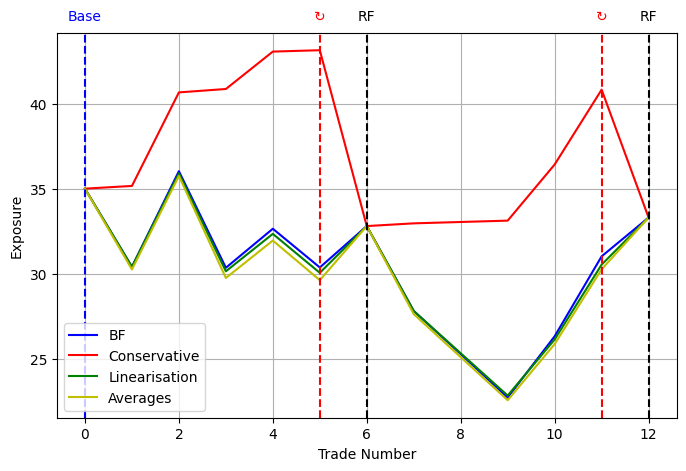

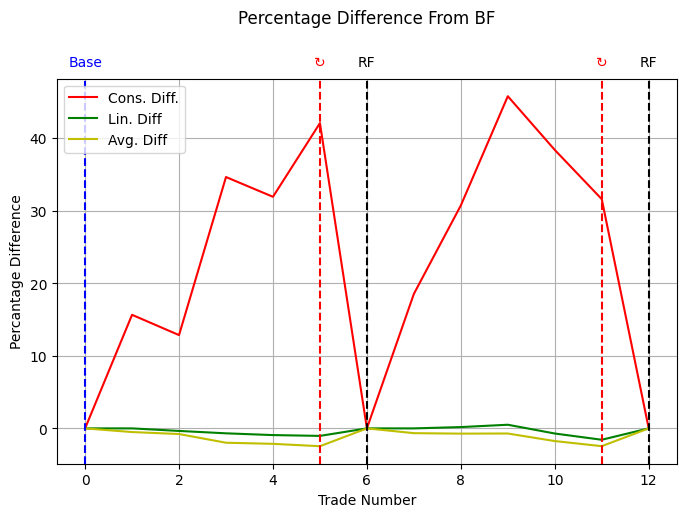

In [22]:
def exposure_simulation(n,m, addonfactor, baseline_mtm, baseline_notional, MtM_min, MtM_max):   

    # Randomly generate our dataset
    # update_position_impacts(n, baseline_mtm, baseline_notional, MtM_min, MtM_max)
    # positions = position_impacts_state["data"]
    
    positions = get_position_impacts(n, baseline_mtm, baseline_notional, MtM_min, MtM_max)

    singleposition = False

    # Set up the following lists to store the exposures for each trade
    bf_list = []
    cons_list = []
    lin_list = []
    avg_list = []

    # Add the initial exposure for the baseline trade
    bf_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
    lin_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
    cons_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
    avg_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))


    # We iterate through the list. Once we hit m trades, we update the baseline and repeat
    for i in range(int(n/m)):
        
        cumulative_positions = np.zeros((0, 2))  # empty to start
        cumulative_positions = np.vstack([cumulative_positions, positions[0, :]])

        for j in range(m):
            
            # Add the next position to the cumulative set
            cumulative_positions = np.vstack([cumulative_positions, positions[j+1 + m*i, :]])

            # Perform the PSR calculations for each strategy
            NGR_BF = PSR_NGR(cumulative_positions, addonfactor, singleposition)
            NGR_Lin = PSR_Linear(cumulative_positions, addonfactor)
            NGR_Cons = PSR_Conservative(cumulative_positions, addonfactor)
            NGR_Avg = PSR_Average(cumulative_positions, addonfactor, m)

            # Append results to respective lists
            bf_list.append(NGR_BF)
            lin_list.append(NGR_Lin)
            cons_list.append(NGR_Cons)
            avg_list.append(NGR_Avg)

        # Re-calculate the baseline by adding in the processed impacts
        mtmRefresh = np.sum(cumulative_positions[:,0])
        notionalRefresh = np.sum(cumulative_positions[:,1])

        # Update the first row (baseline)
        positions[0,0] = max(0,mtmRefresh)
        positions[0,1] = notionalRefresh

        # Add this baseline calculation to the dataset
        bf_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
        lin_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
        cons_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))
        avg_list.append(PSR_NGR(np.array([positions[0,:]]), addonfactor, singleposition))

    #print(remove_decimal_places(bf_list))

    # POST-PROCESSING
    # Below we plot our results
    x = np.linspace(0, n+int(n/m), n+int(n/m)+1)


    

    if n % m == 0:
        
        plt.figure(figsize=(8,5))
        plt.grid(True)
        plt.plot(x, bf_list, 'b', label = "BF")
        plt.plot(x, cons_list, 'r', label = "Conservative")
        plt.plot(x, lin_list, 'g', label = "Linearisation")
        plt.plot(x, avg_list, 'y', label = "Averages")
        plt.xlabel("Trade Number")
        plt.ylabel("Exposure")

        # We will add in vertical lines to indicate the points in the dataset when a refresh is carried out
        for i in range(int(n/m)):

            vline_x = (i+1)*(m+1)
            ymin, ymax = plt.ylim()
            plt.axvline(vline_x, color='k', linestyle='--')
            vline_x2 = (i+1)*(m+1)-1
            ymin2, ymax2 = plt.ylim()
            plt.axvline(vline_x2, color='r', linestyle='--')
            plt.text(vline_x, ymax + (ymax - ymin)*0.025, 'RF', ha="center", va = "bottom", color="k")
            plt.text(vline_x2, ymax2 + (ymax2 - ymin2)*0.025, '↻', ha="center", va = "bottom", color="r")

        vline_start = 0
        ymin3, ymax3 = plt.ylim()
        plt.axvline(vline_start, color='b', linestyle='--')
        plt.text(vline_start, ymax3 + (ymax3 - ymin3)*0.025, 'Base', ha="center", va = "bottom", color="b")

        plt.legend()
        plt.show()


        lin_diff = [(lin_list[i] - bf_list[i])/bf_list[i]*100 for i in range(len(bf_list))]
        cons_diff = [(cons_list[i] - bf_list[i])/bf_list[i]*100 for i in range(len(cons_list))]
        avg_diff = [(avg_list[i] - bf_list[i])/bf_list[i]*100 for i in range(len(avg_list))]


        plt.figure(figsize=(8,5))
        plt.grid(True)
        plt.plot(x, cons_diff, 'r', label = "Cons. Diff.")
        plt.plot(x, lin_diff, 'g', label = "Lin. Diff")
        plt.plot(x, avg_diff, 'y', label = "Avg. Diff")
        plt.xlabel("Trade Number")
        plt.ylabel("Percantage Difference")

        # We will add in vertical lines to indicate the points in the dataset when a refresh is carried out
        for i in range(int(n/m)):

            vline_x = (i+1)*(m+1)
            ymin, ymax = plt.ylim()
            plt.axvline(vline_x, color='k', linestyle='--')
            vline_x2 = (i+1)*(m+1)-1
            ymin2, ymax2 = plt.ylim()
            plt.axvline(vline_x2, color='r', linestyle='--')
            plt.text(vline_x, ymax + (ymax - ymin)*0.025, 'RF', ha="center", va = "bottom", color="k")
            plt.text(vline_x2, ymax2 + (ymax2 - ymin2)*0.025, '↻', ha="center", va = "bottom", color="r")

        vline_start = 0
        ymin3, ymax3 = plt.ylim()
        plt.axvline(vline_start, color='b', linestyle='--')
        plt.text(vline_start, ymax3 + (ymax3 - ymin3)*0.025, 'Base', ha="center", va = "bottom", color="b")

        plt.title("Percentage Difference From BF", pad=40)
        plt.legend()
        plt.subplots_adjust(hspace=0.5)
        plt.show()
        # Below we print our results
        '''
        print("Positions Matrix \n", positions)
        
        print("\n")
        
        print("BF list ", remove_decimal_places(bf_list))
        print("Lin List", remove_decimal_places(lin_list))
        
        print("\n")
        
        print("Conservative List", remove_decimal_places(cons_list))
        print("Average List", remove_decimal_places(avg_list))
        '''
    else:
        print("\n")
        print("ERROR: you must choose n and m such that m divides n (ie. n / m is a whole number)")




exposure_simulation(10,5, 0.01, 25, 1000, -5, 5)


#### **INTERACT:** Use the interactive graph below to analyse how the baseline refresh operates for different parameter values and datasets! 

In [23]:
'''

interact(exposure_simulation,
         n=widgets.IntSlider(min=1, max=100, step=1, value=10, description="# of Trades"),
         m=widgets.IntSlider(min=1, max=100, step=1, value =5, description="Refresh Cycle"),
         addonfactor = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),
         baseline_mtm = widgets.IntSlider(min=10, max=100000, step=10, value=1000, description="MTM Baseline"),
         baseline_notional = widgets.IntSlider(min=1000, max=1000000, step=100, value=100000, description="Notional Baseline"),
         MtM_min = widgets.IntSlider(min=-1000, max=-10, step=1, value =-50, description="MtM Min"),         
         MtM_max = widgets.IntSlider(min=10, max=1000, step=1, value=50, description="MtM Max"),
         )
'''

'\n\ninteract(exposure_simulation,\n         n=widgets.IntSlider(min=1, max=100, step=1, value=10, description="# of Trades"),\n         m=widgets.IntSlider(min=1, max=100, step=1, value =5, description="Refresh Cycle"),\n         addonfactor = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),\n         baseline_mtm = widgets.IntSlider(min=10, max=100000, step=10, value=1000, description="MTM Baseline"),\n         baseline_notional = widgets.IntSlider(min=1000, max=1000000, step=100, value=100000, description="Notional Baseline"),\n         MtM_min = widgets.IntSlider(min=-1000, max=-10, step=1, value =-50, description="MtM Min"),         \n         MtM_max = widgets.IntSlider(min=10, max=1000, step=1, value=50, description="MtM Max"),\n         )\n'

In [24]:

# Define interactive controls
n_slider = widgets.IntSlider(min=1, max=100, step=1, value=10, description="# of Trades")
m_slider = widgets.IntSlider(min=1, max=100, step=1, value=5, description="Refresh Cycle")
addonfactor_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.01, description="AddOnFactor")
baseline_mtm_slider = widgets.IntSlider(min=10, max=100000, step=10, value=1000, description="MTM Baseline")
baseline_notional_slider = widgets.IntSlider(min=1000, max=1000000, step=100, value=100000, description="Notional Baseline")
MtM_min_slider = widgets.IntSlider(min=-1000, max=-10, step=1, value=-50, description="MtM Min")
MtM_max_slider = widgets.IntSlider(min=10, max=1000, step=1, value=50, description="MtM Max")

# Preset button functionality
def set_preset_1(b):
    n_slider.value = 30
    m_slider.value = 10
    addonfactor_slider.value = 0.01
    baseline_mtm_slider.value = 10000
    baseline_notional_slider.value = 500000
    MtM_min_slider.value = -100
    MtM_max_slider.value = 100

def set_preset_2(b):
    n_slider.value = 30
    m_slider.value = 10
    addonfactor_slider.value = 0.01
    baseline_mtm_slider.value = 500
    baseline_notional_slider.value = 50000
    MtM_min_slider.value = -100
    MtM_max_slider.value = 100

def set_preset_3(b):
    n_slider.value = 30
    m_slider.value = 3
    addonfactor_slider.value = 0.01
    baseline_mtm_slider.value = 10000
    baseline_notional_slider.value = 500000
    MtM_min_slider.value = -100
    MtM_max_slider.value = 100

def set_preset_4(b):
    n_slider.value = 30
    m_slider.value = 3
    addonfactor_slider.value = 0.01
    baseline_mtm_slider.value = 500
    baseline_notional_slider.value = 50000
    MtM_min_slider.value = -100
    MtM_max_slider.value = 100

# Create preset buttons
preset_button_1 = widgets.Button(description="Large Baseline, Small Impacts, Infreq. Refreshes")
preset_button_2 = widgets.Button(description="Small Baseline, Large Impacts, Infreq. Refreshes")
preset_button_3 = widgets.Button(description="Large Baseline, Small Impacts, Freq. Refreshes")
preset_button_4 = widgets.Button(description="Small Baseline, Large Impacts, Freq. Refreshes")

preset_button_1.on_click(set_preset_1)
preset_button_2.on_click(set_preset_2)
preset_button_3.on_click(set_preset_3)
preset_button_4.on_click(set_preset_4)

preset_button_1.layout = Layout(width='350px', height='50px')
preset_button_2.layout = Layout(width='350px', height='50px')
preset_button_3.layout = Layout(width='350px', height='50px')
preset_button_4.layout = Layout(width='350px', height='50px')

# Create grid layout for sliders
grid_layout = widgets.GridBox(
    children=[n_slider, m_slider, addonfactor_slider, baseline_mtm_slider, baseline_notional_slider, MtM_min_slider, MtM_max_slider],
    layout=Layout(grid_template_columns="repeat(3, 300px)", grid_template_rows="repeat(3, auto)", grid_gap="10px")
)

# Layout for buttons
button_layout = widgets.HBox([preset_button_1, preset_button_2, preset_button_3, preset_button_4])

# Display interactive widgets and function output
ui = widgets.VBox([grid_layout, button_layout])
out = widgets.interactive_output(exposure_simulation, {
    'n': n_slider, 
    'm': m_slider, 
    'addonfactor': addonfactor_slider, 
    'baseline_mtm': baseline_mtm_slider, 
    'baseline_notional': baseline_notional_slider, 
    'MtM_min': MtM_min_slider, 
    'MtM_max': MtM_max_slider
})

display(ui, out)

Output()

#### **Analysis:** Percentage Growth

- We are curious to see how much a certain strategy grows. 
- What we can do is take each list and analyse the percentage difference from the brute force approach. 
- After that, we can plot the results for each, and then pick the largest number from the set as a metric for how much a method grew 
- As before, we can set up an interactive graph that has different presets to test certain scenarios !

### Observations on Dataset Impact (INCOMPLETE)

1. WORK ON THIS SECTION AND SHOW YOUR FINDINGS